# Transferência de Aprendizagem com VGG-16

## Etapa 1 - Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

## Etapa 2 - Conectando com o Drive e acessando os arquivos

In [ ]:
path = "../Material/fer2013.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
base_imgs = '../Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./")
zip_object.close()

## Etapa 3 - Acessando a base com fotos de expressões faciais



In [ ]:
diretorio = '../Material/'

data = pd.read_csv(diretorio + 'fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


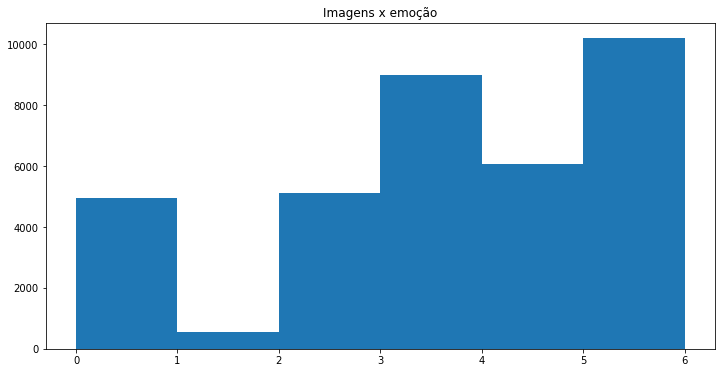

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=6)
plt.title("Imagens x emoção")
plt.show()

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

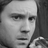

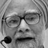

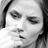

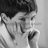

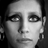

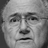

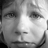

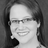

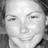

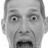

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
pixels = data['pixels'].tolist()
largura, altura = 48, 48

faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura, 1)
  # As imagens da nossa base estão em grayscale (escala de cinza) então precisaremos converter para RGB
  # para realizar isso vamos replicar o valor grayscale para cada um dos 3 canais, por exemplo: antes=(255) | depois=(255,255,255)
  # isso pode ser feito com o comando abaixo:
  face = np.asarray(np.dstack((face, face, face)), dtype=np.uint8)
  # o shape será alterado de (largura, altura) para (largura, altura, 3)
  # precisamos deixar com 3 canais de cor pois a rede VGG-16 foi treinada com imagens coloridas, então ela aceita como input imagens de 3 dimensões (3 canais de cor)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)

  amostras = amostras + 1

faces = np.asarray(faces)

def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)

emocoes = pd.get_dummies(data['emotion']).as_matrix()

In [ ]:
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 35887


## Etapa 5 - Imports do Tensorflow/Keras

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications import VGG16

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de testes: 3589
Número de imagens no conjunto de validação: 3230


In [ ]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

## Etapa 7 - Arquitetura do Modelo (CNN)

### Arquitetura do modelo

Vamos utilizar o modelo da VGG-16, este que possui pesos treinados com o dataset ImageNet, que é um conjunto de dados composto por mais de 14 milhões de imagens classificadas em 1000 classes.

![alt text](https://drive.google.com/uc?id=1vFKAnNPuQ_eHxeaoscwRtB5P2Gg1kyhM)

**Arquitetura da VGG-16** ([créditos da imagem](https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c))

In [ ]:
num_classes = 7
width, height = 48, 48
batch_size = 16
epochs = 30

vgg = VGG16(input_shape=(width, height, 3), weights='imagenet', include_top=False)

In [ ]:
vgg.trainable=False
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes,activation='softmax')

* É importante congelar as camadas convolucionais antes de compilar e treinar o modelo.
* Ao congelar ou definir layer.trainable = False, você evita que os pesos em uma determinada camada sejam atualizados durante o treinamento.

In [ ]:
model = Sequential([
  vgg,
  global_average_layer,
  prediction_layer
])

(para maiores explicações do porquê fizemos isso leia o texto mais abaixo)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


## Etapa 8 - Compilando o modelo

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = diretorio + "modelo_vgg_expressoes.h5" # arquivo do modelo
arquivo_modelo_json = diretorio + "modelo_vgg_expressoes.json" # arquivo do json, para salvar a arquitetura
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [ ]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

## Etapa 9 - Treinando o modelo

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(x_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Train on 29068 samples, validate on 3230 samples
Epoch 1/30
29024/29068 [============================>.] - ETA: 0s - loss: 1.6445 - accuracy: 0.3507
Epoch 00001: val_loss improved from inf to 1.56136, saving model to gdrive/My Drive/Cursos/Deteccao_Expressoes_Faciais/modelo_vgg_expressoes.h5
29068/29068 [==============================] - 18s 633us/sample - loss: 1.6443 - accuracy: 0.3507 - val_loss: 1.5614 - val_accuracy: 0.3972
Epoch 2/30
29056/29068 [============================>.] - ETA: 0s - loss: 1.5652 - accuracy: 0.3939
Epoch 00002: val_loss improved from 1.56136 to 1.53613, saving model to gdrive/My Drive/Cursos/Deteccao_Expressoes_Faciais/modelo_vgg_expressoes.h5
29068/29068 [==============================] - 18s 603us/sample - loss: 1.5651 - accuracy: 0.3939 - val_loss: 1.5361 - val_accuracy: 0.4102
Epoch 3/30
29024/29068 [============================>.] - ETA: 0s - loss: 1.5387 - accuracy: 0.4085
Epoch 00003: val_loss improved from 1.53613 to 1.52508, saving model to gdrive/

## Gerando gráfico da melhora em cada etapa do treinamento

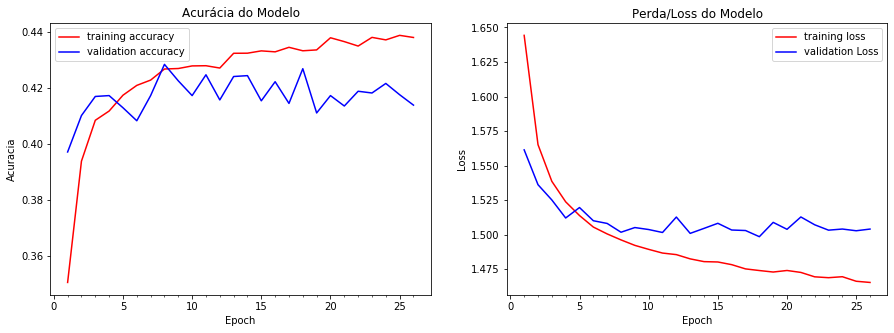

In [ ]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Carregaremos os dados para gerar a matriz de confusão

In [ ]:
true_y=[]
pred_y=[]
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 40.0947339091669%


## Gerando a Matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')
cm = confusion_matrix(y_true, y_pred)
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
titulo='Matriz de Confusão'
print(cm)

[[125   1  31 145  74  28  94]
 [ 14   1   5   9  11   2  10]
 [ 65   2  89 132 110  69  78]
 [ 64   0  27 550  96  38 106]
 [ 63   0  32 150 211  15 117]
 [ 19   0  33  86  20 211  45]
 [ 47   2  28 176  76  30 252]]


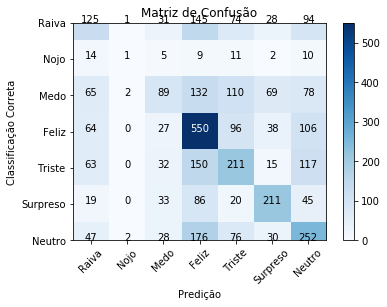

In [ ]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')
plt.show()

## Testando brevemente o modelo

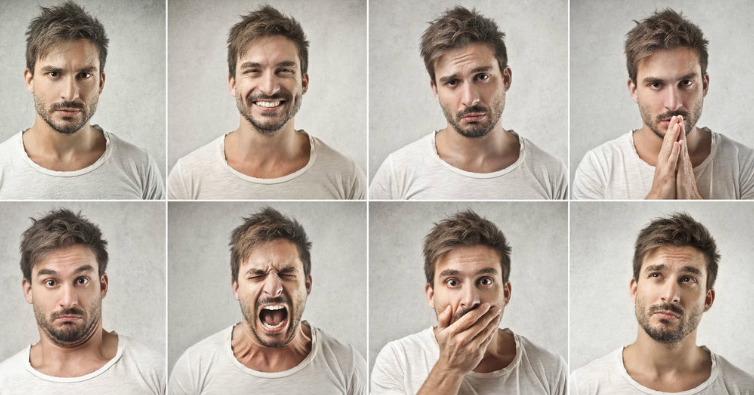

In [ ]:
imagem = cv2.imread(diretorio + "testes/teste02.jpg")
cv2_imshow(imagem)

In [ ]:
model = load_model(diretorio + "modelo_vgg_expressoes.h5")
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

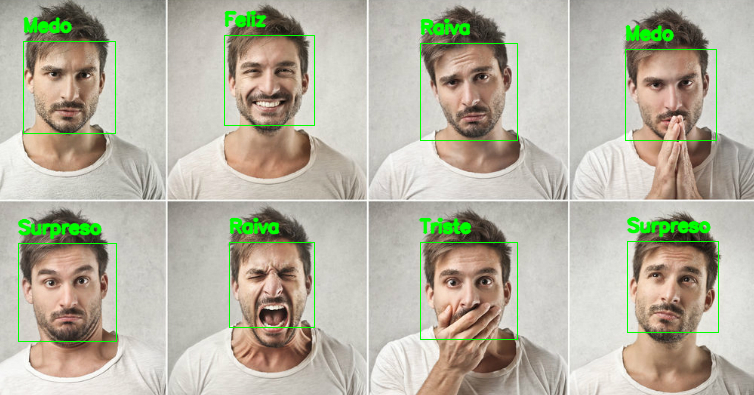

In [ ]:
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(diretorio + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
    roi_gray = roi_gray.astype("float") / 255.0
    # também não usaremos o np.expand_dims(, -1)
    cropped_img = np.expand_dims(cv2.resize(roi_gray, (48, 48)), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1,
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(original)